In [ ]:
"""
Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.  

SPDX-License-Identifier: CC-BY-NC-4.0
"""

In [ ]:
from defects_module.base import PauliT, Pos
from defects_module.code_library import RotatedSurfaceCode
from defects_module.defects import DefectiveSurfaceCode, PauliT, Heuristics
from defects_module.plot import plot
from defects_module.simulate import get_logical_error_rate
from defects_module.utils import memory_program, standard_noise
import matplotlib.pyplot as plt

## How to use the module

Please note that we print warnings whenever strategies are dropped during the global optimization phase when doing the boundary deformation, usually because the code did not find a valid corner placement.

In [2]:
# First we define the undamaged patch
undamaged_patch = RotatedSurfaceCode(5)

# Second we define the defects in the patch
ancilla_defects = set([Pos(4, 4)])
data_defects = set([Pos(1, 1), Pos(1, 3)])
link_defects = set([])

# Produce some damaged patches
_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
)
for patch in damaged_patches:
    print(f"(horizontal, vertical distance) = {patch.effective_distance}")

Found 1 defect clusters.
Strategy dropped: Did not find four corners to draw boundaries.
(horizontal, vertical distance) = (4, 5)


In [3]:
# Plot the outputs.
figs = [plot(damaged_patch) for damaged_patch in damaged_patches]
for fig in figs:
    fig.show()

In [4]:
# First we define the undamaged patch
undamaged_patch = RotatedSurfaceCode(7)

# Second we define the defects in the patch
ancilla_defects = set([Pos(4, 4)])
data_defects = set([Pos(9, 3), Pos(5, 5)])
link_defects = set([(Pos(6, 6), Pos(7, 7)), (Pos(6, 8), Pos(7, 7))])

# Produce some damaged patches
_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
)
for patch in damaged_patches:
    print(f"(horizontal, vertical distance) = {patch.effective_distance}")

# Plot the outputs.
figs = [plot(damaged_patch) for damaged_patch in damaged_patches]
for fig in figs:
    fig.show()

Found 1 defect clusters.
(horizontal, vertical distance) = (5, 4)
(horizontal, vertical distance) = (4, 5)


## Logical memory experiment

In [5]:
# First we define the undamaged patch
undamaged_patch = RotatedSurfaceCode(7, vertical_logical=PauliT.Z)

# Second we define the defects in the patch
ancilla_defects = set([Pos(4, 4)])
data_defects = set()
link_defects = set([(Pos(6, 6), Pos(7, 7)), (Pos(6, 8), Pos(7, 7))])

# Produce some damaged patches
_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
)
damaged_patch = damaged_patches[0]
print(f"(horizontal, vertical distance) = (d_X, d_Z) = {damaged_patch.effective_distance}")

# Run some memory experiments
# X basis memory
circ_X = memory_program(damaged_patch, standard_noise(1e-3), rounds=14, pauli=PauliT.X)
p_Z = get_logical_error_rate(circ_X, num_shots=100_000)
# Z basis memory
circ_Z = memory_program(damaged_patch, standard_noise(1e-3), rounds=14, pauli=PauliT.Z)
p_X = get_logical_error_rate(circ_Z, num_shots=100_000)
print(p_X, p_Z)

Found 1 defect clusters.
(horizontal, vertical distance) = (d_X, d_Z) = (6, 6)
6e-05 0.0002


In [6]:
# Calculate logical error rate for different values of physical error rate
error_rates = [0.004, 0.005, 0.006, 0.007, 0.008]
num_shots = 50_000  # this is a low number of shots for speed
rounds = 14
defects_logical_p_X = []
defects_logical_p_Z = []
undamaged_logical_p_X = []
undamaged_logical_p_Z = []
# Sweep over physical error rate
for p in error_rates:
    noise = standard_noise(p)

    circ_X = memory_program(damaged_patch, noise, rounds=rounds, pauli=PauliT.X)
    p_Z = get_logical_error_rate(circ_X, num_shots=num_shots)
    circ_Z = memory_program(damaged_patch,noise, rounds=rounds, pauli=PauliT.Z)
    p_X = get_logical_error_rate(circ_Z, num_shots=num_shots)
    defects_logical_p_X.append(p_X)
    defects_logical_p_Z.append(p_Z)

    circ_X = memory_program(undamaged_patch, noise, rounds=rounds, pauli=PauliT.X)
    p_Z = get_logical_error_rate(circ_X, num_shots=num_shots)
    circ_Z = memory_program(undamaged_patch, noise, rounds=rounds, pauli=PauliT.Z)
    p_X = get_logical_error_rate(circ_Z, num_shots=num_shots)
    undamaged_logical_p_X.append(p_X)
    undamaged_logical_p_Z.append(p_Z)


Text(0, 0.5, 'Logical error rate (14 rounds)')

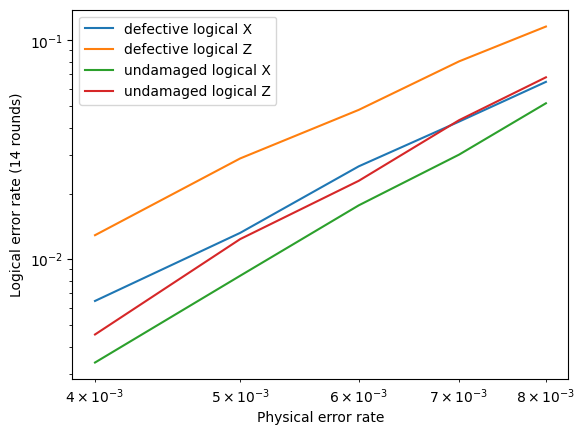

In [7]:
fig, ax = plt.subplots()
ax.plot(error_rates, defects_logical_p_X, label="defective logical X")
ax.plot(error_rates, defects_logical_p_Z, label="defective logical Z")
ax.plot(error_rates, undamaged_logical_p_X, label="undamaged logical X")
ax.plot(error_rates, undamaged_logical_p_Z, label="undamaged logical Z")
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel("Physical error rate")
ax.set_ylabel("Logical error rate (14 rounds)")

## Heuristics

We can also use heuristics: force efficient checks and drop lossy ones to make the algorithm faster.

In [8]:
%%time 
# First with no heuristics.

undamaged_patch = RotatedSurfaceCode(9, vertical_logical=PauliT.Z)
ancilla_defects = {Pos(4, 4), Pos(6, 18), Pos(14, 12), Pos(16, 6)}
data_defects = {Pos(3, 7), Pos(7, 11), Pos(7, 5), Pos(15, 17)}
link_defects = {(Pos(6, 6), Pos(7, 7)), (Pos(14, 4), Pos(13, 5)), (Pos(14, 6), Pos(15, 7))}

_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
)
damaged_patch = damaged_patches[0]
print(f"(horizontal, vertical distance) = (d_X, d_Z) = {damaged_patch.effective_distance}")

Found 6 defect clusters.
(horizontal, vertical distance) = (d_X, d_Z) = (5, 6)
CPU times: user 30.4 s, sys: 223 ms, total: 30.6 s
Wall time: 30.8 s


In [9]:
plot(damaged_patch)

In [10]:
%%time 
# Now we employ a weak heuristic. We are still doing a significant amount of global optimization
weak_heuristic = Heuristics(n_sol_max_per_cluster=10, n_sol_max=100)

undamaged_patch = RotatedSurfaceCode(9, vertical_logical=PauliT.Z)
ancilla_defects = {Pos(4, 4), Pos(6, 18), Pos(14, 12), Pos(16, 6)}
data_defects = {Pos(3, 7), Pos(7, 11), Pos(7, 5), Pos(15, 17)}
link_defects = {(Pos(6, 6), Pos(7, 7)), (Pos(14, 4), Pos(13, 5)), (Pos(14, 6), Pos(15, 7))}

_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
    use_heuristics=weak_heuristic
)
damaged_patch = damaged_patches[0]
print(f"(horizontal, vertical distance) = (d_X, d_Z) = {damaged_patch.effective_distance}")

Found 6 defect clusters.
(horizontal, vertical distance) = (d_X, d_Z) = (5, 6)
CPU times: user 13.1 s, sys: 90.8 ms, total: 13.2 s
Wall time: 13.2 s


In [11]:
plot(damaged_patch)

In [12]:
%%time 
# Now we employ a moderate heuristic, we are considering a max of 10 strategies for global optimization
moderate_heuristic = Heuristics(n_sol_max_per_cluster=3, n_sol_max=10, n_skip=10)

undamaged_patch = RotatedSurfaceCode(9, vertical_logical=PauliT.Z)
ancilla_defects = {Pos(4, 4), Pos(12, 2), Pos(6, 18), Pos(14, 12), Pos(16, 6)}
data_defects = {Pos(3, 7), Pos(7, 11), Pos(7, 5), Pos(15, 17)}
link_defects = {(Pos(6, 6), Pos(7, 7)), (Pos(14, 4), Pos(13, 5)), (Pos(14, 6), Pos(15, 7))}

_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
    use_heuristics=moderate_heuristic
)
damaged_patch = damaged_patches[0]
print(f"(horizontal, vertical distance) = (d_X, d_Z) = {damaged_patch.effective_distance}")

Found 6 defect clusters.
(horizontal, vertical distance) = (d_X, d_Z) = (5, 6)
CPU times: user 286 ms, sys: 3.14 ms, total: 290 ms
Wall time: 289 ms


In [13]:
plot(damaged_patch)

In [14]:
%%time 
# Now we employ a strong heuristic, we are considering a max of 10 strategies for global optimization
strong_heuristic = Heuristics(link_defect_to_ancilla=True, n_zombie=10, n_max=2, n_sum=2, n_sol_max_per_cluster=2, n_sol_max=2)

undamaged_patch = RotatedSurfaceCode(9, vertical_logical=PauliT.Z)
ancilla_defects = {Pos(4, 4), Pos(12, 2), Pos(6, 18), Pos(14, 12), Pos(16, 6)}
data_defects = {Pos(3, 7), Pos(7, 11), Pos(7, 5), Pos(15, 17)}
link_defects = {(Pos(6, 6), Pos(7, 7)), (Pos(14, 4), Pos(13, 5)), (Pos(14, 6), Pos(15, 7))}

_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    first_super_type=PauliT.X,
    use_heuristics=strong_heuristic
)
damaged_patch = damaged_patches[0]
print(f"(horizontal, vertical distance) = (d_X, d_Z) = {damaged_patch.effective_distance}")

Found 6 defect clusters.
(horizontal, vertical distance) = (d_X, d_Z) = (5, 6)
CPU times: user 183 ms, sys: 2.44 ms, total: 186 ms
Wall time: 185 ms


In [15]:
plot(damaged_patch)

## Making subpatches

In [16]:
L = 3
undamaged_patch = RotatedSurfaceCode(distance=(2 * L + 1, 2 * L + 1))

data_defects = {Pos(*x) for x in {}}
ancilla_defects = {Pos(*x) for x in {(2, 12), (4, 4), (10, 4), (14, 2)}}
link_defects = {
    (Pos(*x), Pos(*y)) for x, y in {((5, 5), (6, 6)), ((3, 11), (4, 10)), ((1, 5), (2, 4))}
}
heuristics = Heuristics(n_sol_max_per_cluster=10, n_sol_max=100)

_, damaged_patches = DefectiveSurfaceCode.make_defective_patches(
    undamaged_patch,
    ancilla_defects,
    data_defects,
    link_defects,
    repurpose_ancillas=True,
    add_padding=True,
    use_heuristics=heuristics,
    first_super_type=PauliT.X,
)

patch = damaged_patches[0]
plot(patch)

Found 1 defect clusters.
Strategy dropped: Had frozen qubit (3, 13) along boundary (probably due to an invalid corner placement).
Strategy dropped: Had frozen qubit (3, 9) along boundary (probably due to an invalid corner placement).
Strategy dropped: Had frozen qubit (3, 13) along boundary (probably due to an invalid corner placement).
Strategy dropped: Had frozen qubit (3, 9) along boundary (probably due to an invalid corner placement).
Strategy dropped: Had frozen qubit (3, 13) along boundary (probably due to an invalid corner placement).
Strategy dropped: Had frozen qubit (3, 9) along boundary (probably due to an invalid corner placement).


In [17]:
ancilla_patch = patch.make_subpatch(3, sw_offset=Pos(1,1))
control_patch = patch.make_subpatch(3, sw_offset=Pos(1,9))
target_patch = patch.make_subpatch(3, sw_offset=Pos(9,1))
plot(ancilla_patch, control_patch, target_patch)